# Feature Analysis and Selection

In this notebook, the initial feature set, consisting of temperature features and sin/cos of the temporal features, is extended and quality checked. Finally, the feature set is reduced.

In [8]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt


In [9]:
target_cols = ['APPARENT_TEMPERATURE:TOTAL',
       'ATMOSPHERIC_PRESSURE:TOTAL', 'PRECIPITATION_RATE:TOTAL',
       'PROBABILITY_OF_PRECIPITATION:TOTAL', 'RELATIVE_HUMIDITY:TOTAL',
       'TEMPERATURE:TOTAL', 'WIND_DIRECTION:TOTAL', 'WIND_GUST_SPEED:TOTAL',
       'date_month_sin', 'date_month_cos',  'date_is_holiday',
       'date_is_weekday', 'date_is_weekend', 'date_season', 'hour_sin',
       'hour_cos', 'hour_sin_2x', 'hour_cos_2x', 'hour_sin_4x', 'hour_cos_4x',
       'day_sin', 'day_cos', 'Agg Load_']

weather_cols = ['APPARENT_TEMPERATURE:TOTAL',
       'ATMOSPHERIC_PRESSURE:TOTAL', 'PRECIPITATION_RATE:TOTAL',
       'PROBABILITY_OF_PRECIPITATION:TOTAL', 'RELATIVE_HUMIDITY:TOTAL',
       'TEMPERATURE:TOTAL', 'WIND_DIRECTION:TOTAL', 'WIND_GUST_SPEED:TOTAL']

df_hh = pd.read_pickle("./data/1920 Final Data w. Additional Features HH Hourly Agg.pkl")
df_hh = df_hh[target_cols]
df_hp = pd.read_pickle("./data/1920 Final Data w. Additional Features HP Hourly Agg.pkl")
df_hp = df_hp[target_cols]


df_comb = df_hh.copy()
df_comb["Agg Load_"] = df_comb["Agg Load_"] + df_hp["Agg Load_"]



### Feature building

In [10]:
df_hh.isna().sum()

APPARENT_TEMPERATURE:TOTAL            0
ATMOSPHERIC_PRESSURE:TOTAL            0
PRECIPITATION_RATE:TOTAL              0
PROBABILITY_OF_PRECIPITATION:TOTAL    0
RELATIVE_HUMIDITY:TOTAL               0
TEMPERATURE:TOTAL                     0
WIND_DIRECTION:TOTAL                  0
WIND_GUST_SPEED:TOTAL                 0
date_month_sin                        0
date_month_cos                        0
date_is_holiday                       0
date_is_weekday                       0
date_is_weekend                       0
date_season                           0
hour_sin                              0
hour_cos                              0
hour_sin_2x                           0
hour_cos_2x                           0
hour_sin_4x                           0
hour_cos_4x                           0
day_sin                               0
day_cos                               0
Agg Load_                             0
dtype: int64

In [11]:
# Building the same load feature

def create_same_hour_df(df:pd.DataFrame, lookback_days: int, focus_col=str):
    temp_df = df.copy()
    hour_shifts = [24*(x+1) for x in range(lookback_days)] # determine hourly shifts
    for hour_shift in hour_shifts: # create hourly shift in dataframe
        temp_df[str(hour_shift)] = temp_df[focus_col].shift(hour_shift) 

    hour_shift_columns = [str(x) for x in hour_shifts]

    shift_sum = temp_df[hour_shift_columns].sum(axis=1)/lookback_days
    return shift_sum


In [12]:
dfs = [df_hh, df_hp, df_comb]
focus_col = "Agg Load_"

for df in dfs:
    # create same hour col
    same_hour_col = create_same_hour_df(df,7, focus_col)
    df["load_same_hour_last_7_days"] = same_hour_col
    
    for weather_col in weather_cols: # create weather col a perfect forecast
        df[weather_col] = df[weather_col].shift(-24)

    # create rolling means
    df["APPARENT_TEMPERATURE:TOTAL ROLLING "+str(24)] = df["APPARENT_TEMPERATURE:TOTAL"].rolling(24).mean()
    df["APPARENT_TEMPERATURE:TOTAL ROLLING "+str(48)] = df["APPARENT_TEMPERATURE:TOTAL"].rolling(48).mean()
        
    df_agg_load = df[focus_col]
    df.drop(focus_col,inplace=True,axis=1)
    df[focus_col] = df_agg_load   
    
    # drop_na
    df.ffill(inplace=True) # using a ffill to insert dummy values for the weather observations at the last day, which will not be used during the forecast
    df.dropna(inplace=True) # dropping nan values, which is especially true for the first day (no lag load available e.g.)
    
    df.rename(columns = {'Agg Load_':'Agg Load'}, inplace = True)



In [13]:
df

,APPARENT_TEMPERATURE:TOTAL,ATMOSPHERIC_PRESSURE:TOTAL,PRECIPITATION_RATE:TOTAL,PROBABILITY_OF_PRECIPITATION:TOTAL,RELATIVE_HUMIDITY:TOTAL,TEMPERATURE:TOTAL,WIND_DIRECTION:TOTAL,WIND_GUST_SPEED:TOTAL,date_month_sin,date_month_cos,...,hour_sin_2x,hour_cos_2x,hour_sin_4x,hour_cos_4x,day_sin,day_cos,load_same_hour_last_7_days,APPARENT_TEMPERATURE:TOTAL ROLLING 24,APPARENT_TEMPERATURE:TOTAL ROLLING 48,Agg Load
date,,,,,,,,,,,,,,,,,,,,,
2019-01-02 23:00:00+00:00,-3.866667,1036.808360,0.0,35.000000,95.0,-1.375000,300.0,4.652778,5.000000e-01,0.866025,...,-4.898587e-16,1.000000,-9.797174e-16,1.000000,8.660254e-01,-0.5,4436.117065,-3.426389,-2.167969,36327.901995
2019-01-03 00:00:00+00:00,-4.408333,1036.633301,0.0,38.333333,95.0,-1.500000,300.0,4.953704,5.000000e-01,0.866025,...,0.000000e+00,1.000000,0.000000e+00,1.000000,1.224647e-16,-1.0,8140.960758,-3.402778,-2.234288,35464.373476
2019-01-03 01:00:00+00:00,-4.541667,1036.524994,0.0,40.000000,95.0,-1.291667,300.0,5.532407,5.000000e-01,0.866025,...,5.195840e-01,0.854419,8.878852e-01,0.460065,1.224647e-16,-1.0,7935.029834,-3.397917,-2.303385,36708.840474
2019-01-03 02:00:00+00:00,-4.966667,1036.383362,0.0,37.083333,95.0,-1.425000,300.0,6.087963,5.000000e-01,0.866025,...,8.878852e-01,0.460065,8.169699e-01,-0.576680,1.224647e-16,-1.0,7759.872564,-3.395139,-2.384201,35719.997511
2019-01-03 03:00:00+00:00,-5.233333,1036.308370,0.0,40.000000,95.0,-1.533333,300.0,6.342593,5.000000e-01,0.866025,...,9.976688e-01,-0.068242,-1.361666e-01,-0.990686,1.224647e-16,-1.0,7330.549721,-3.372569,-2.475694,34857.671640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00+00:00,1.200000,1005.000000,0.1,50.000000,90.0,1.200000,200.0,4.444445,-2.449294e-16,1.000000,...,-8.169699e-01,-0.576680,9.422609e-01,-0.334880,1.224647e-16,-1.0,27326.356794,-0.266319,-0.322743,30587.419588
2020-12-31 20:00:00+00:00,1.200000,1005.000000,0.1,50.000000,90.0,1.200000,200.0,4.444445,-2.449294e-16,1.000000,...,-9.976688e-01,-0.068242,1.361666e-01,-0.990686,1.224647e-16,-1.0,24185.633367,-0.266319,-0.322743,24249.875910
2020-12-31 21:00:00+00:00,1.200000,1005.000000,0.1,50.000000,90.0,1.200000,200.0,4.444445,-2.449294e-16,1.000000,...,-8.878852e-01,0.460065,-8.169699e-01,-0.576680,1.224647e-16,-1.0,21659.159769,-0.266319,-0.322743,24439.704660


### Pearson correlation

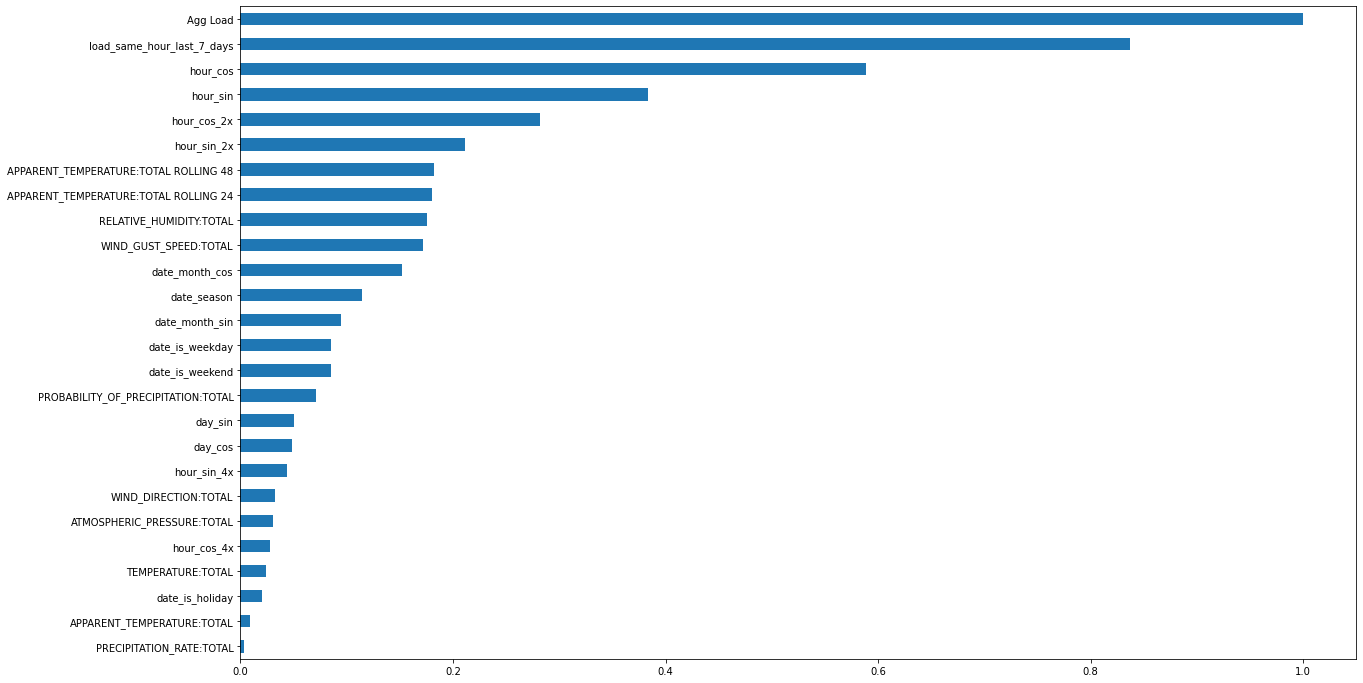

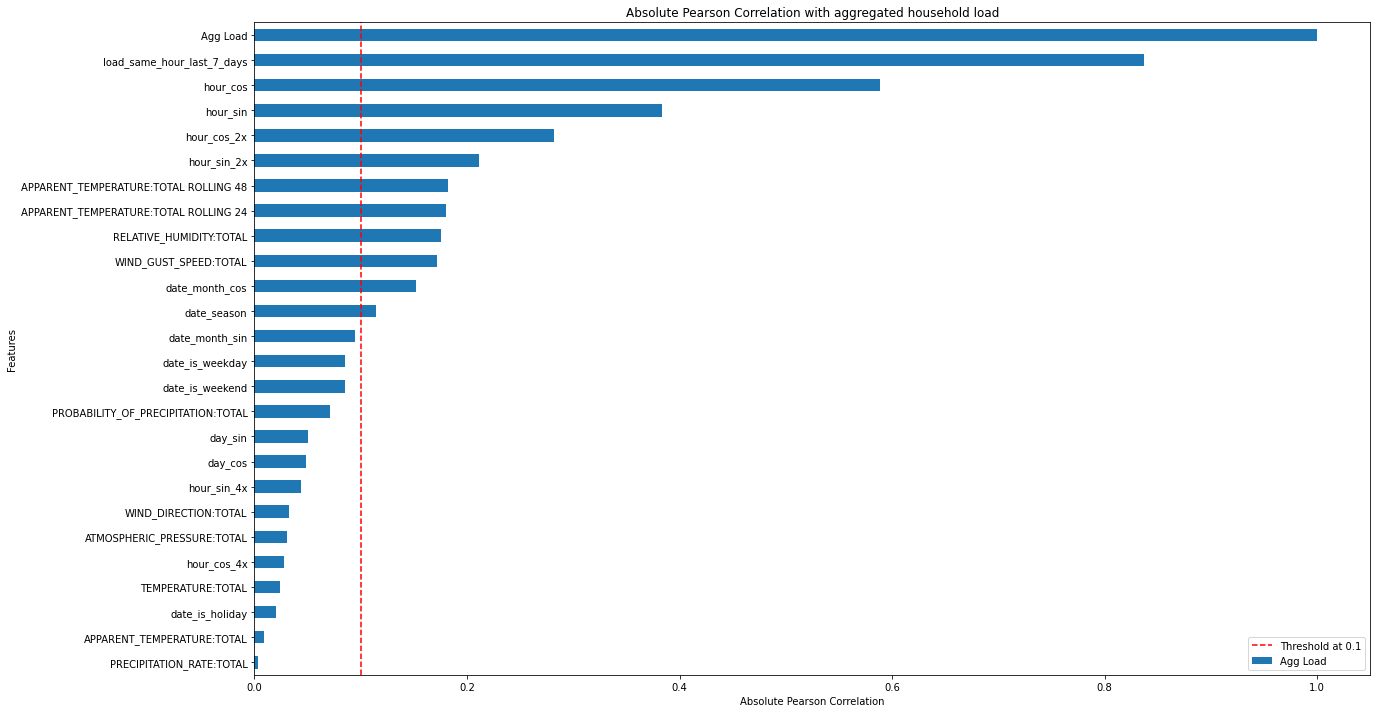

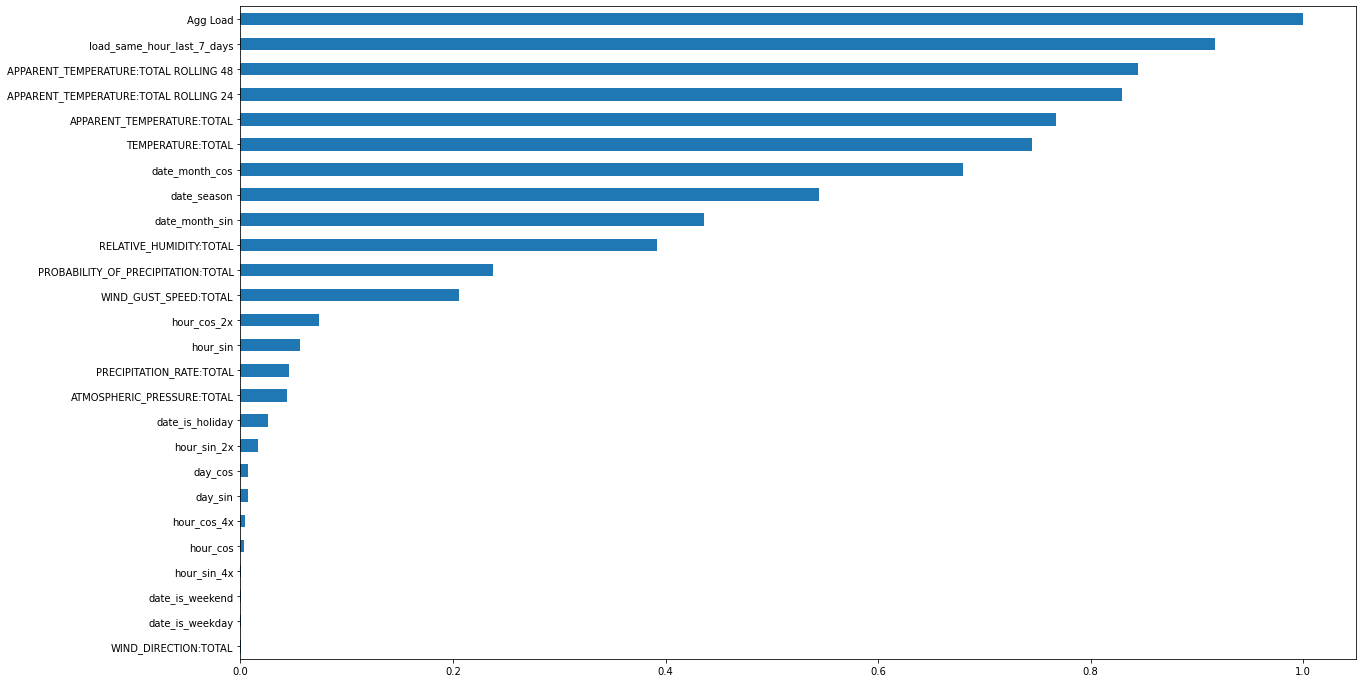

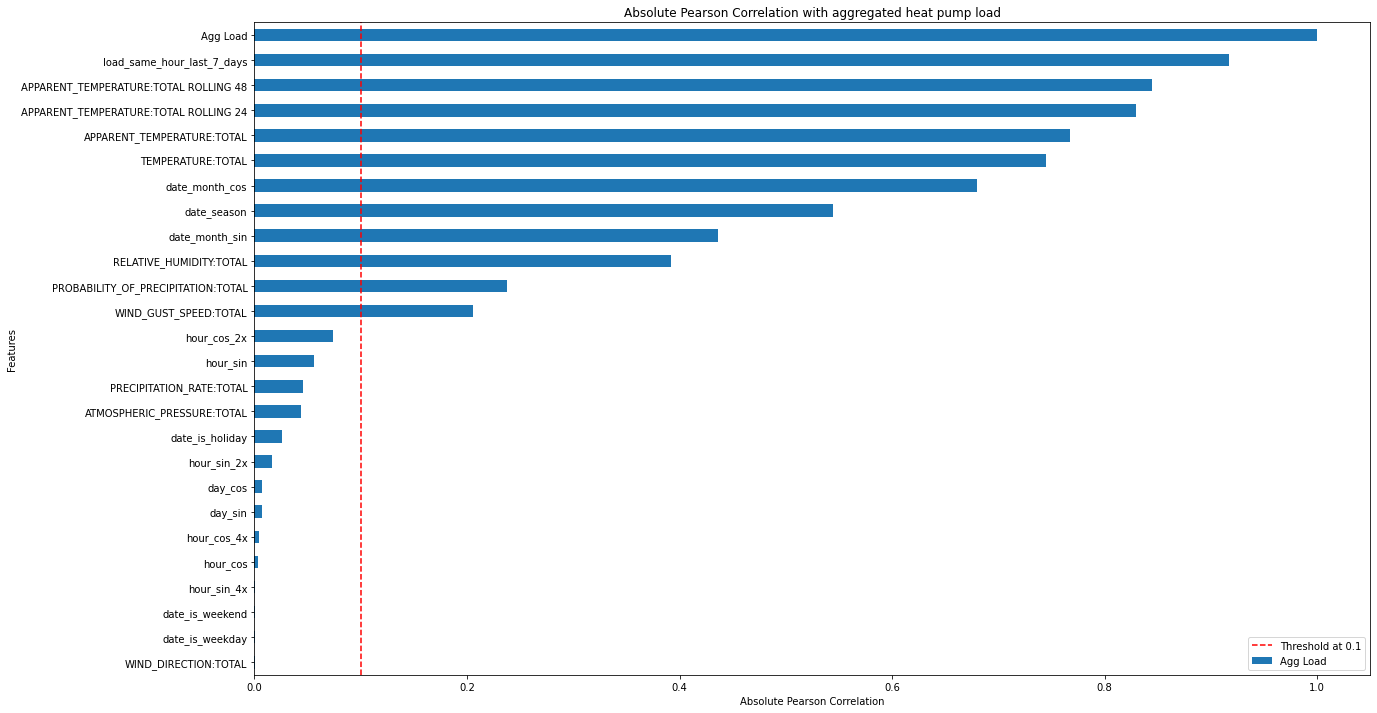

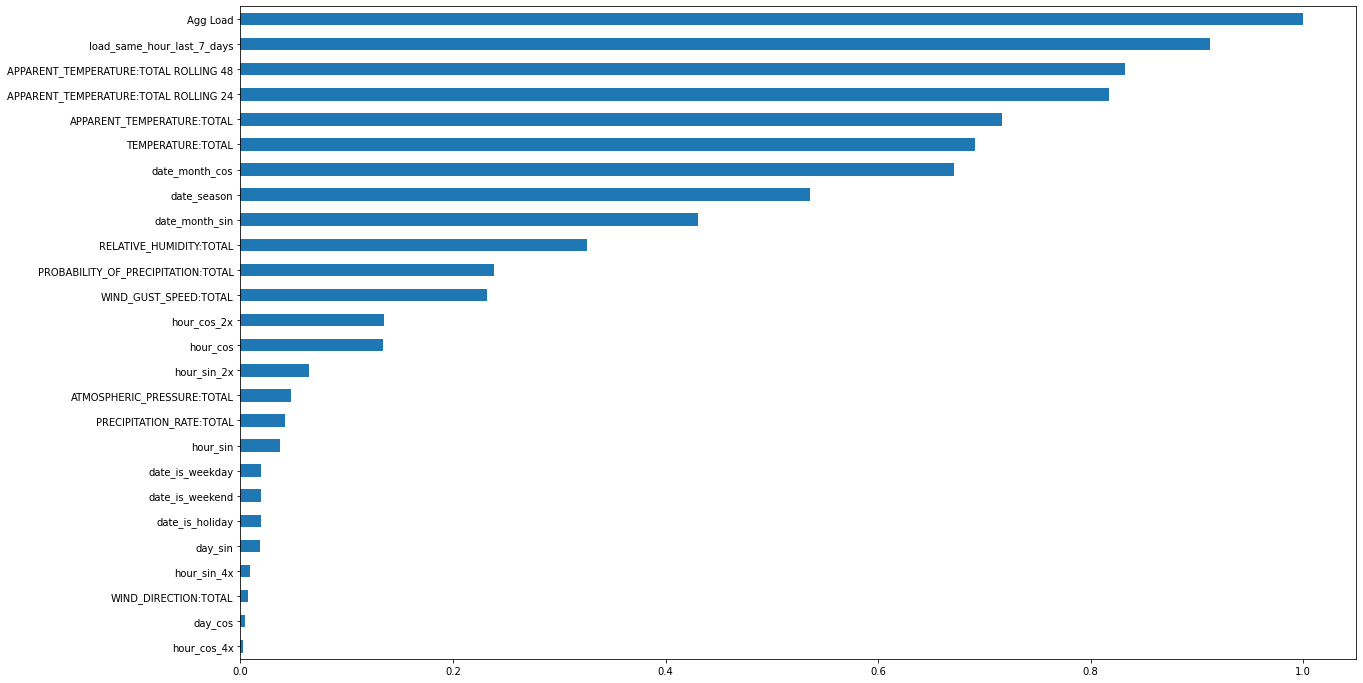

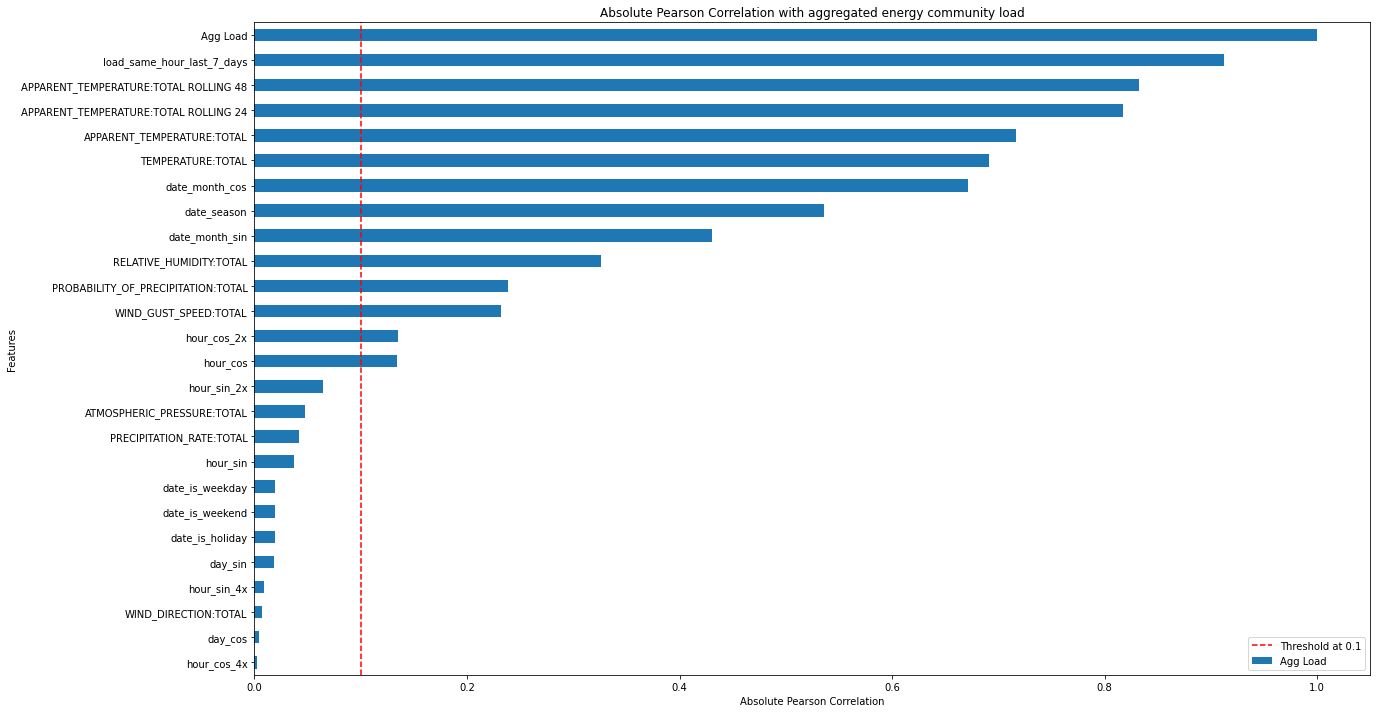

In [14]:

# setting pearson correlation at 0.1: https://www.sciencedirect.com/science/article/pii/S2666827021000323

correlation = 0.1
relevant_cols_pearson = []
df_names = ["aggregated household load","aggregated heat pump load","aggregated energy community load"]

for idx, df in enumerate(dfs):
    pearson_corrs = df.corr()["Agg Load"].abs()
    pearson_corrs.sort_values().plot.barh(figsize=(20,12))

    # Create the horizontal bar plot
    plt.figure(figsize=(20, 12))
    pearson_corrs.sort_values().plot.barh()

    # Add a vertical line at 0.3
    plt.axvline(x=correlation, color='red', linestyle='--', label='Threshold at '+str(correlation))

    # Set labels and title
    plt.xlabel('Absolute Pearson Correlation')
    plt.ylabel('Features')
    plt.title('Absolute Pearson Correlation with '+df_names[idx])

    # Show legend
    plt.legend()

    # Show the plot
    plt.show()
    
    relevant_cols_pearson.append(pearson_corrs[pearson_corrs>correlation].keys().to_list())



In [15]:
# Correlation and instance based feature selection for electricity load forecasting AND Evaluating Feature Selection Methods for Short-term Load Forecasting --> 10 RF features
# Filter-Wrapper method: Hybrid filter–wrapper feature selection for short-term load forecasting


<Figure size 1440x864 with 0 Axes>

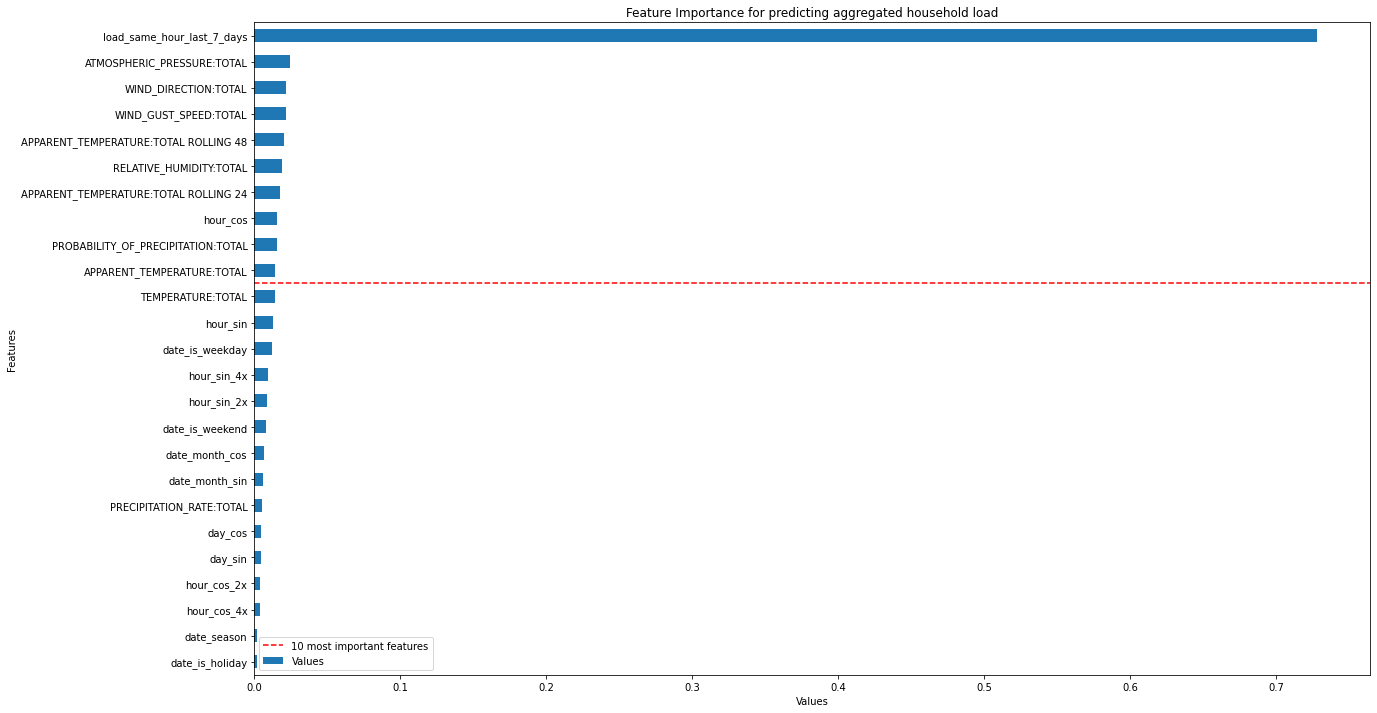

<Figure size 1440x864 with 0 Axes>

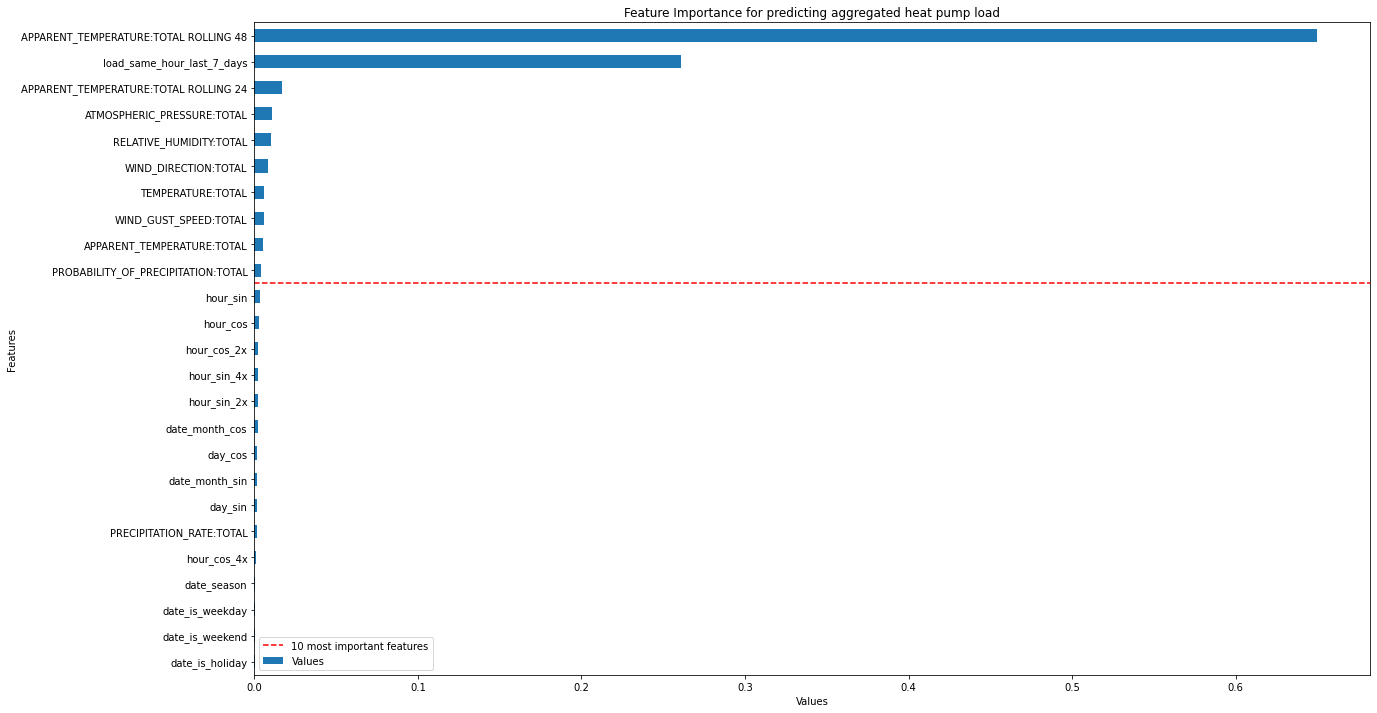

<Figure size 1440x864 with 0 Axes>

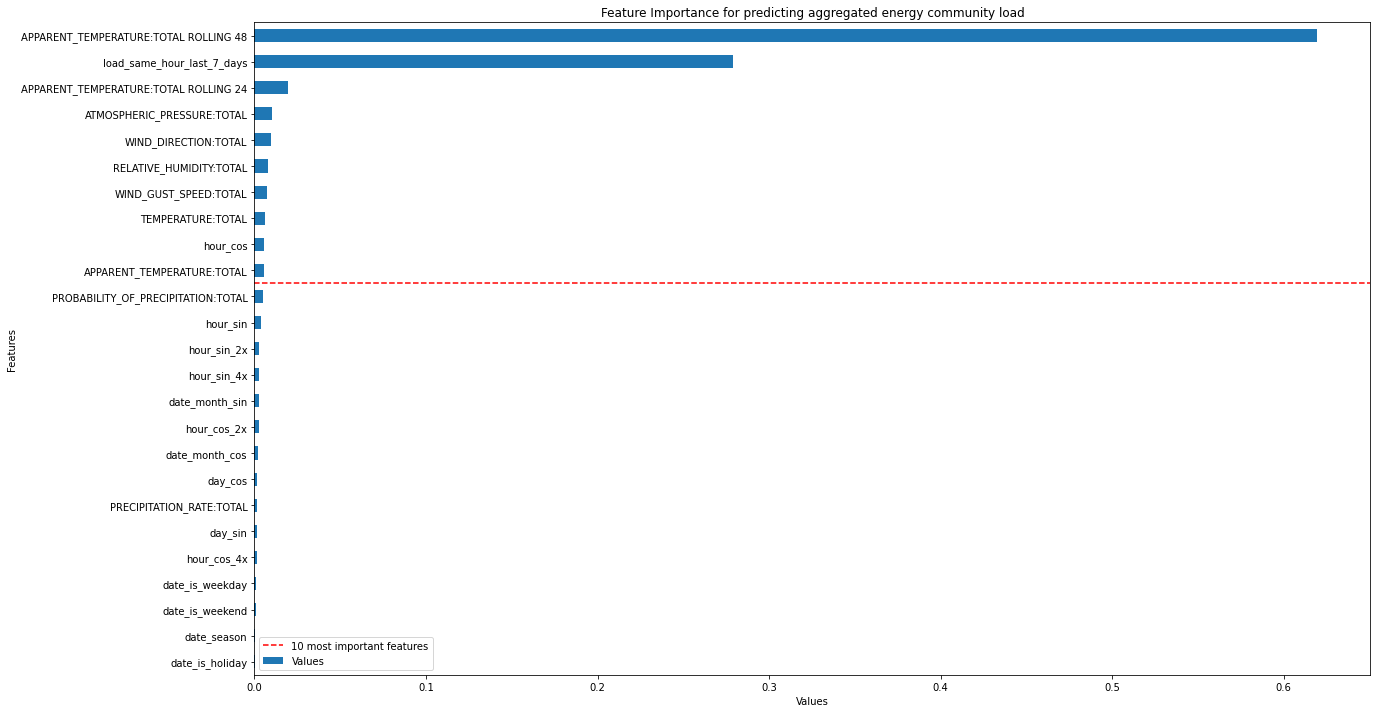

In [16]:
relevant_cols_rf = []


for idx, df in enumerate(dfs):
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(df[df.columns[:-1]], df[df.columns[-1]])

    df_importance_rf = pd.DataFrame()
    df_importance_rf["Features"] = df.columns[:-1]
    df_importance_rf["Values"] = rf.feature_importances_
    df_importance_rf.set_index("Features").sort_values("Values",ascending=False)


    # Create the horizontal bar plot
    plt.figure(figsize=(20, 12))
    df_importance_rf.set_index("Features").sort_values("Values",ascending=True).plot.barh(figsize=(20,12))
    

    # Calculate the number of bars to skip (last 10 bars)
    num_bars_to_skip = 10

    # Determine the y-coordinate for the horizontal line
    y_coord = len(df_importance_rf) - num_bars_to_skip - 0.5  # Subtract 0.5 for alignment

    # Add a horizontal line
    plt.axhline(y=y_coord, color='red', linestyle='--', label='10 most important features')

    # Set labels and title
    plt.xlabel('Values')
    plt.ylabel('Features')
    plt.title('Feature Importance for predicting '+df_names[idx])

    # Show legend
    plt.legend()

    # Show the plot
    plt.show()

    relevant_cols_rf.append(df_importance_rf.sort_values("Values",ascending=False).head(10)["Features"].to_list())


    

In [17]:
combined_features = [list(set(cols_rf) & set(cols_pearson)) for cols_rf, cols_pearson in zip(relevant_cols_rf, relevant_cols_pearson)]
skip = [x.append("Agg Load") for x in combined_features]

for combined_feature in combined_features:
    if "hour_sin" not in combined_feature:
        combined_feature.append("hour_sin")
    if "hour_cos" not in combined_feature:
        combined_feature.append("hour_cos")



In [21]:
for idx, df in enumerate(dfs):
    cols_at_end = ['Agg Load']
    df = df[combined_features[idx]]
    df = df[[c for c in df if c not in cols_at_end] 
        + [c for c in cols_at_end if c in df]]
    df.to_pickle("./data/Feature Selection "+df_names[idx]+".pkl")

In [22]:
df

,RELATIVE_HUMIDITY:TOTAL,hour_cos,WIND_GUST_SPEED:TOTAL,APPARENT_TEMPERATURE:TOTAL ROLLING 48,TEMPERATURE:TOTAL,APPARENT_TEMPERATURE:TOTAL,APPARENT_TEMPERATURE:TOTAL ROLLING 24,load_same_hour_last_7_days,hour_sin,Agg Load
date,,,,,,,,,,
2019-01-02 23:00:00+00:00,95.0,1.000000,4.652778,-2.167969,-1.375000,-3.866667,-3.426389,4436.117065,-2.449294e-16,36327.901995
2019-01-03 00:00:00+00:00,95.0,1.000000,4.953704,-2.234288,-1.500000,-4.408333,-3.402778,8140.960758,0.000000e+00,35464.373476
2019-01-03 01:00:00+00:00,95.0,0.962917,5.532407,-2.303385,-1.291667,-4.541667,-3.397917,7935.029834,2.697968e-01,36708.840474
2019-01-03 02:00:00+00:00,95.0,0.854419,6.087963,-2.384201,-1.425000,-4.966667,-3.395139,7759.872564,5.195840e-01,35719.997511
2019-01-03 03:00:00+00:00,95.0,0.682553,6.342593,-2.475694,-1.533333,-5.233333,-3.372569,7330.549721,7.308360e-01,34857.671640
...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00+00:00,90.0,0.460065,4.444445,-0.322743,1.200000,1.200000,-0.266319,27326.356794,-8.878852e-01,30587.419588
2020-12-31 20:00:00+00:00,90.0,0.682553,4.444445,-0.322743,1.200000,1.200000,-0.266319,24185.633367,-7.308360e-01,24249.875910
2020-12-31 21:00:00+00:00,90.0,0.854419,4.444445,-0.322743,1.200000,1.200000,-0.266319,21659.159769,-5.195840e-01,24439.704660


In [146]:
# Finally, features that pass both feature selection methods are included in the final dataset
combined_features

[['APPARENT_TEMPERATURE:TOTAL ROLLING 48',
  'APPARENT_TEMPERATURE:TOTAL ROLLING 24',
  'WIND_GUST_SPEED:TOTAL',
  'same_hour_last_7_days',
  'hour_cos',
  'RELATIVE_HUMIDITY:TOTAL',
  'Agg Load'],
 ['PROBABILITY_OF_PRECIPITATION:TOTAL',
  'TEMPERATURE:TOTAL',
  'APPARENT_TEMPERATURE:TOTAL ROLLING 48',
  'APPARENT_TEMPERATURE:TOTAL ROLLING 24',
  'WIND_GUST_SPEED:TOTAL',
  'APPARENT_TEMPERATURE:TOTAL',
  'same_hour_last_7_days',
  'RELATIVE_HUMIDITY:TOTAL',
  'Agg Load'],
 ['TEMPERATURE:TOTAL',
  'APPARENT_TEMPERATURE:TOTAL ROLLING 48',
  'APPARENT_TEMPERATURE:TOTAL ROLLING 24',
  'WIND_GUST_SPEED:TOTAL',
  'APPARENT_TEMPERATURE:TOTAL',
  'same_hour_last_7_days',
  'hour_cos',
  'RELATIVE_HUMIDITY:TOTAL',
  'Agg Load']]